# Data recording and analysis

<div class="admonition note">
**Topics**: Spatial data saving, Data visualization, HDF5 format, XDMF format, Paraview.
</div>

As we just saw in the previous chapter, recording and analyzing data can quickly become relatively code-intensive when the complexity of the model and geometry increases. In this chapter we will introduce database handlers that will let us record data from different simulations to a database (either [SQLite](https://www.sqlite.org/index.html) or [HDF5](https://www.hdfgroup.org/solutions/hdf5)). We will then present a specialized database handler that uses the [XDMF](https://www.xdmf.org/index.php/Main_Page) file format to easily record spatial data and visualize it with  Paraview, a scientific visualization software.

Since the focus will be put on the recording part of STEPS script, we will use a very simple model and geometry in this chapter. We will model the [Brusselator](https://en.wikipedia.org/wiki/Brusselator) chemical oscillator. We will first use a well-mixed geometry in order to introduce the parameter-saving capabilities of databases.

The Brusselator model contains the following reactions:
\begin{equation}
A \rightarrow X
\end{equation}

\begin{equation}
X \rightarrow E
\end{equation}

\begin{equation}
B + X \rightarrow Y + D
\end{equation}

\begin{equation}
2X + Y \rightarrow 3X
\end{equation}

We consider $A$ and $B$ to be in vast excess so that the reactions do not significantly change their concentrations. We can then treat them as parameters $k_A$ and $k_B$ in the first and third reactions. We also ignore product species $D$ and $E$ that are not further involved in the reactions. The reduced system is:

\begin{equation}
\varnothing \overset{k_A}{\rightleftarrows} X \overset{k_B}{\rightarrow} Y
\end{equation}

\begin{equation}
2X + Y \rightarrow 3X
\end{equation}

We declare the corresponding biochemical model and the well-mixed geometry as follows:

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.rng import *
from steps.sim import *
from steps.saving import *

import numpy as np

TF = 10
CF = 5e4
A = 1
B = 1

mdl = Model()
r = ReactionManager()
with mdl:
    X, Y = Species.Create()
    vsys = VolumeSystem.Create()
    with vsys:
        None <r['r1']> X >r['r2']> Y
        r['r1'].K = A * TF / CF, TF
        r['r2'].K = B * TF

        2*X + Y >r['r3']> 3*X
        r['r3'].K = TF * (CF ** 2)
        
geom = Geometry()
with geom:
    comp = Compartment.Create(vsys, vol=1e-19)

Note that we declare a time factor `TF` and a concentration factor `CF` to scale the values of rate constants appropriately. We thus have $k_A = A \times \frac{\mathrm{TF}}{\mathrm{CF}}$ and $k_B = B \times \mathrm{TF}$.
As we will later want to modify the rate constants of reactions, we give them names (`'r1'`, `'r2'`, `'r3'`).

We then create the simulation and setup data saving for the concentrations of `X` and `Y` in the compartment:

In [272]:
ENDT = 20
SIM_DT = 0.05

rng = RNG('mt19937', 512, 1234)

sim = Simulation('Wmrk4', mdl, geom, rng)
sim.setDT(5e-5)

rs = ResultSelector(sim)

concs = rs.comp.LIST(X, Y).Conc

sim.toSave(concs, dt=SIM_DT)

Model checking:
No errors were found


Instead of using `'Wmdirect'` as solver, we are using `'Wmrk4'` which is a deterministic solver implementing the 4th order [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). This solver requires setting an integration timestep with `sim.setDT(5e-5)`. We then specify that the concentrations of `X` and `Y` should be saved every `SIM_DT=0.05` seconds, as we did in previous chapters.

In order to investigate the effects of parameters $A$ and $B$ on the behaviour of the system, we will run several simulations with different values of these parameters. Normally, we would have to either save the data to different files with e.g. `concs.toFile('Brusselator_A0.1_B1.dat')` or save all the data in a single file and mix all runs regardless of the parameter values. The former solution creates a lot of files and requires parsing the file name to recover the parameter values. The latter solution requires manually writing another file keeping track of which run corresponds to which parameter set.

To solve this type of issues, STEPS allows users to save results from groups of runs, along with their parameters, to a database. In order to do so, we need to use a database handler class. Currently, STEPS implements two of them:
- [SQLiteDBHandler](API_saving.rst#steps.API_2.saving.SQLiteDBHandler) that saves to an [SQLite](https://www.sqlite.org/index.html) database;
- and [HDF5Handler](API_saving.rst#steps.API_2.saving.HDF5Handler) that saves to an [HDF5](https://www.hdfgroup.org/solutions/hdf5) file.

In this chapter we will use [HDF5Handler](API_saving.rst#steps.API_2.saving.HDF5Handler) but their interfaces are nearly identical, so everything we will see also applies to [SQLiteDBHandler](API_saving.rst#steps.API_2.saving.SQLiteDBHandler).

Here is our main run loop, wrapped with the database handler:

In [ ]:
# Simulation parameters
AVals = np.linspace(0, 2, 21).round(2)
BVals = np.linspace(0, 5, 21).round(2)

with HDF5Handler('Brusselator_wm') as hdf:
    for A in AVals:
        for B in BVals:
            sim.toDB(hdf, f'WM_A{A}_B{B}', A=A, B=B)

            sim.newRun()

            sim.comp.r1.K = (A * TF / CF), TF
            sim.comp.r2.K = B * TF
            sim.comp.r3.K = TF * (CF ** 2)

            sim.run(ENDT)

In order to save our data to an HDF5 file, we first need to create the database handler with `HDF5Handler('Brusselator_wm')`. The string corresponds to a path and file name prefix. In our case we want to create the HDF5 file in the same directory so we just provide a file prefix. If we needed to create it in another directory we would use e.g. `HDF5Handler('data/Brusselator_wm')`. Note that we provide a file prefix instead of a full file name, STEPS will add the `.h5` extension for us. When running parallel simulations (see the [corresponding chapter](Interface_Tutorial_6_MPI.ipynb)), STEPS will also add information about the process that is saving the file.

This database handler object is then used in a context manager block `with HDF5Handler('Brusselator_wm') as hdf:` this will allow STEPS to automatically close the file when this block is exited. We need to use the `as hdf` part to give it a name.
We then write the double `for` loop that will explore all combinations of `A` and `B` parameter values.

Before calling `sim.newRun()`, we need to signalize the start of a new run group to the simulation. This is done by calling `sim.toDB(hdf, f'WM_A{A}_B{B}', A=A, B=B)` which will redirect all data saving to the `hdf` database handler. It requires a unique string identifier for the run group (`f'WM_A{A}_B{B}'`) and can then optionally take keyword arguments that are parameters of the run group.

In this case, since the solver is deterministic, we only have one run per run group. But if we wanted several runs per run group we could write e.g.:
```python
NBRUNS = 10

with HDF5Handler('Brusselator_stoch') as hdf:
    for A in AVals:
        for B in BVals:
            sim.toDB(hdf, f'Stoch_A{A}_B{B}', A=A, B=B)

            for r in range(NBRUNS):
                sim.newRun()

                sim.comp.r1.K = (A * TF / CF), TF
                sim.comp.r2.K = B * TF
                sim.comp.r3.K = TF * (CF ** 2)

                sim.run(ENDT)
```
As long as `sim.toDB(hdf, ...)` is not called again, all the runs are associated to the last created run group.

Wrapping our simulation loop with e.g. `with HDF5Handler('Brusselator_wm') as hdf:` and calling e.g. `sim.toDB(hdf, f'WM_A{A}_B{B}', A=A, B=B)` for each run group is thus all we have to do to save our results to a database.
After this block, `Brusselator_wm.h5` is written in the current directory. We can then see how to open it and read data from it:

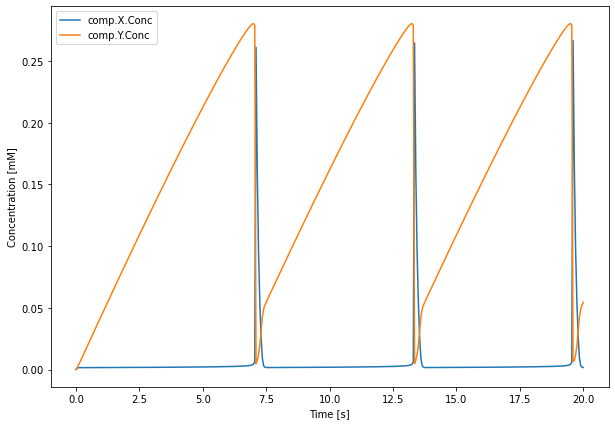

In [123]:
from matplotlib import pyplot as plt

with HDF5Handler('Brusselator_wm') as hdf:
    group = hdf.get(A=0.3, B=3)
    
    concs, = group.results
    
    fig = plt.figure(figsize=(10,7))
    
    # Plot data for run 0
    plt.plot(concs.time[0], 1e3 * concs.data[0,:,:])
    
    plt.xlabel('Time [s]')
    plt.ylabel('Concentration [mM]')
    plt.legend(concs.labels)
    plt.show()

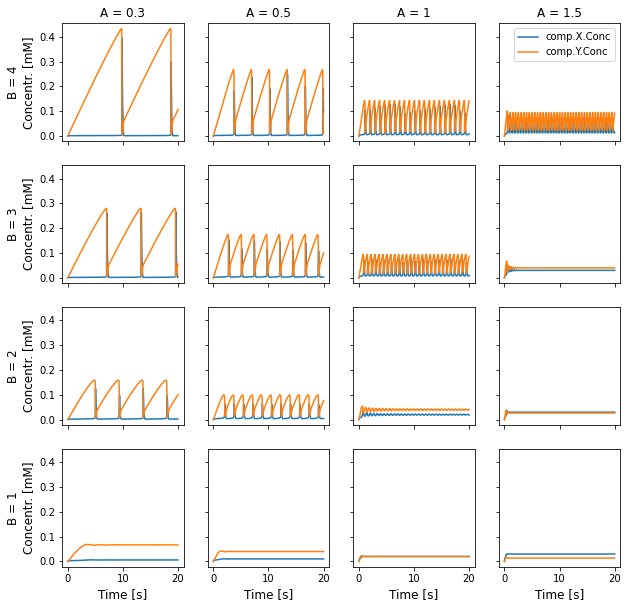

In [164]:
pltAVals = [0.3, 0.5, 1, 1.5]
pltBVals = [4, 3, 2, 1]

with HDF5Handler('Brusselator_wm') as hdf:
    fig, axes = plt.subplots(4, 4, figsize=(10,10), sharey=True, sharex=True)
    
    # Plot data
    for i, B in enumerate(pltBVals):
        for j, A in enumerate(pltAVals):
            concs, = hdf.get(A=A, B=B).results
            axes[i][j].plot(concs.time[0], concs.data[0,:,:] * 1e3)
            
    # Add legend and labels
    axes[0][-1].legend(concs.labels)
    for k in range(4):
        axes[0][k].set_title(f'A = {pltAVals[k]}')
        axes[-1][k].set_xlabel('Time [s]', size='large')
        axes[k][0].set_ylabel(f'B = {pltBVals[k]}\nConcentr. [mM]', size='large')
    plt.show()

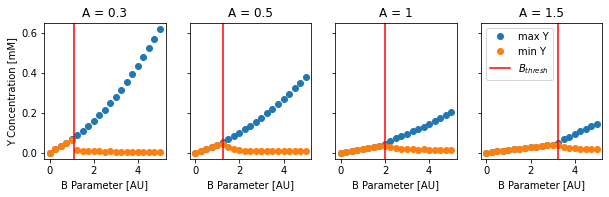

In [273]:
tSkip = int(5 // SIM_DT)

with HDF5Handler('Brusselator_wm') as hdf:
    fig, axes = plt.subplots(1, len(pltAVals), figsize=(10, 2.5), sharey=True)
    
    for A, ax in zip(pltAVals, axes):
        BVals = []
        minMaxVals = []
        for group in hdf.filter(A=A):
            BVals.append(group.B)
            YConc = 1e3 * group.results[0].data[0,tSkip:,1]
            minMaxVals.append([np.max(YConc), np.min(YConc)])

        Bthresh = 1 + A ** 2
        ax.plot(BVals, minMaxVals, 'o')
        ax.axvline(Bthresh, color='r')
        ax.set_xlabel('B Parameter [AU]')
        ax.set_title(f'A = {A}')
    axes[0].set_ylabel('Y Concentration [mM]')
    plt.legend(['max Y', 'min Y', '$B_{thresh}$'], loc=2)
        
plt.show()

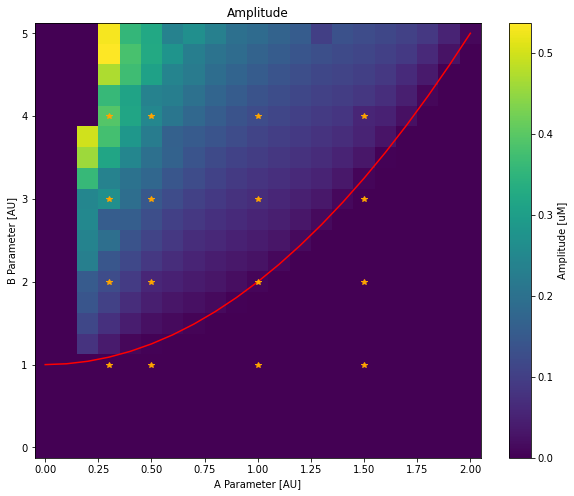

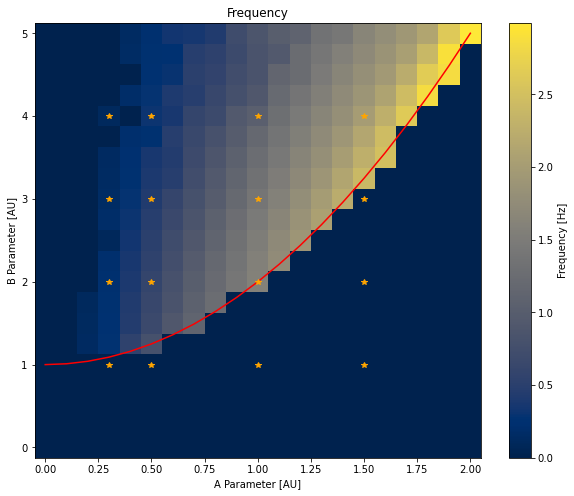

In [271]:
from scipy.signal import find_peaks


pind = 0
with HDF5Handler('Brusselator_wm') as hdf:
    # Get all possible values of parameters A and B
    Avals = sorted(hdf.parameters['A'])
    Bvals = sorted(hdf.parameters['B'])
    
    # Compute amplitudes and frequencies of X peaks
    amplitudes = np.zeros((len(Avals), len(Bvals)))
    frequencies = np.zeros((len(Avals), len(Bvals)))
    for i, B in enumerate(Bvals):
        for j, A in enumerate(Avals):
            concs, = hdf.get(A=A, B=B).results
            time = concs.time[0,tSkip:]
            XConc = concs.data[0,tSkip:,0] * 1e3
            # Compute amplitude
            amplitudes[i,j] = np.max(XConc) - np.min(XConc)
            # Compute frequency
            peaks, _ = find_peaks(XConc, prominence=amplitudes[i,j] * 0.7)
            if len(peaks) > 1:
                frequencies[i,j] = 1 / np.mean(np.diff(time[peaks]))
                
fig = plt.figure(figsize=(10, 8))
plt.pcolormesh(Avals, Bvals, amplitudes)
plt.plot(Avals, [(1 + A ** 2) for A in Avals], '-r')
plt.plot(*np.meshgrid(pltAVals, pltBVals), '*', color='orange')
plt.xlabel('A Parameter [AU]')
plt.ylabel('B Parameter [AU]')
plt.title('Amplitude')
plt.colorbar(label='Amplitude [uM]')

fig = plt.figure(figsize=(10, 8))
plt.pcolormesh(Avals, Bvals, frequencies, cmap=plt.get_cmap('cividis'))
plt.plot(Avals, [(1 + A ** 2) for A in Avals], '-r')
plt.plot(*np.meshgrid(pltAVals, pltBVals), '*', color='orange')
plt.xlabel('A Parameter [AU]')
plt.ylabel('B Parameter [AU]')
plt.colorbar(label='Frequency [Hz]')
plt.title('Frequency')

plt.show()

In [4]:
DCST = 1e-13
A = 0.3
B = 3

mdl2 = Model()
r = ReactionManager()
with mdl2:
    X, Y = Species.Create()
    vsys = VolumeSystem.Create()
    with vsys:
        None <r['r1']> X >r['r2']> Y
        r['r1'].K = A * TF / CF, TF
        r['r2'].K = B * TF

        2*X + Y >r['r3']> 3*X
        r['r3'].K = TF * (CF ** 2)
        
        Diffusion(X, DCST)
        Diffusion(Y, DCST)

In [9]:
ENDT = 1.5
SIM_DT = 0.01

mesh = TetMesh.LoadGmsh('scripts/meshes/square2_9k.msh', scale=1e-6)
with mesh:
    comp = Compartment.Create(mesh.tets, vsys)
    
rng = RNG('mt19937', 512, 1234)

sim = Simulation('Tetexact', mdl2, mesh, rng)

rs = ResultSelector(sim)

concs = rs.TETS().LIST(X, Y).Conc

sim.toSave(concs, dt=SIM_DT)

with XDMFHandler('Brusselator_square') as hdf:
    sim.toDB(hdf, f'square_A{A}_B{B}', A=A, B=B)

    sim.newRun()
    
    sim.comp.X.Conc = 5e-6
    sim.comp.Y.Conc = 1.4e-4

    sim.run(ENDT)

Model checking:
No errors were found


In [8]:
ENDT = 1.5
SIM_DT = 0.01

mesh = TetMesh.LoadGmsh('scripts/meshes/box2_110k.msh', scale=1e-6)
with mesh:
    comp = Compartment.Create(mesh.tets, vsys)
    
rng = RNG('mt19937', 512, 1234)

sim = Simulation('Tetexact', mdl2, mesh, rng)

rs = ResultSelector(sim)

concs = rs.TETS().LIST(X, Y).Conc

sim.toSave(concs, dt=SIM_DT)

with XDMFHandler('Brusselator_box') as hdf:
    sim.toDB(hdf, f'box_A{A}_B{B}', A=A, B=B)

    sim.newRun()

    sim.comp.r1.K = (A * TF / CF), TF
    sim.comp.r2.K = B * TF
    sim.comp.r3.K = TF * (CF ** 2)
    
    sim.comp.X.Conc = 5e-6
    sim.comp.Y.Conc = 1.6e-4

    #sim.run(ENDT)
    N = 100
    for i in range(N+1):
        if MPI.rank == 0:
            print(f'time = {ENDT*i/N} / {ENDT}')
        sim.run(ENDT*i/N)

Model checking:
No errors were found
time = 0.0 / 1.5
time = 0.015 / 1.5
time = 0.03 / 1.5
time = 0.045 / 1.5
time = 0.06 / 1.5
time = 0.075 / 1.5
time = 0.09 / 1.5
time = 0.105 / 1.5
time = 0.12 / 1.5
time = 0.135 / 1.5
time = 0.15 / 1.5
time = 0.165 / 1.5
time = 0.18 / 1.5
time = 0.195 / 1.5
time = 0.21 / 1.5
time = 0.225 / 1.5
time = 0.24 / 1.5
time = 0.255 / 1.5
time = 0.27 / 1.5
time = 0.285 / 1.5
time = 0.3 / 1.5
time = 0.315 / 1.5
time = 0.33 / 1.5
time = 0.345 / 1.5
time = 0.36 / 1.5
time = 0.375 / 1.5
time = 0.39 / 1.5
time = 0.405 / 1.5
time = 0.42 / 1.5
time = 0.435 / 1.5
time = 0.45 / 1.5
time = 0.465 / 1.5
time = 0.48 / 1.5
time = 0.495 / 1.5
time = 0.51 / 1.5
time = 0.525 / 1.5
time = 0.54 / 1.5
time = 0.555 / 1.5
time = 0.57 / 1.5
time = 0.585 / 1.5
time = 0.6 / 1.5
time = 0.615 / 1.5
time = 0.63 / 1.5
time = 0.645 / 1.5
time = 0.66 / 1.5
time = 0.675 / 1.5
time = 0.69 / 1.5
time = 0.705 / 1.5
time = 0.72 / 1.5
time = 0.735 / 1.5
time = 0.75 / 1.5
time = 0.765 / 1.5
time

<iframe src="https://kitware.github.io/paraview-glance/app?name=square.vtkjs&url=https://jules.lallouette.fr/tmp/steps/API_2/square.vtkjs" class="ParaviewFrame"></iframe>
<iframe src="https://kitware.github.io/paraview-glance/app?name=square.vtkjs&url=https://jules.lallouette.fr/tmp/steps/API_2/box_final.vtkjs" class="ParaviewFrame"></iframe>

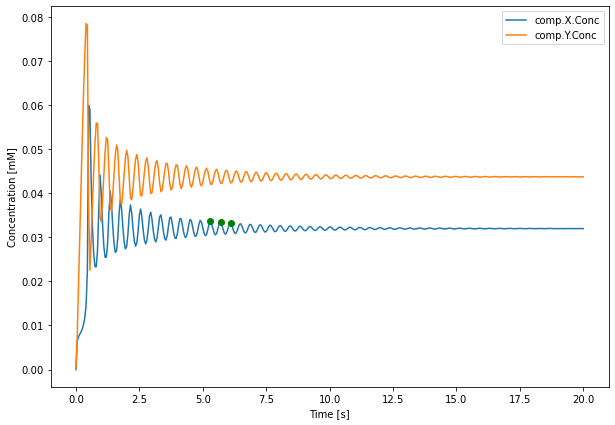

In [254]:
with HDF5Handler('Brusselator_wm') as hdf:
    group = hdf.get(A=1.6, B=3.5)
    #group = hdf.get(A=1.4, B=2.75)
    #group = hdf.get(A=1, B=2)
    
    concs, = group.results
    
    fig = plt.figure(figsize=(10,7))
    
    # Plot data for run 0
    plt.plot(concs.time[0], 1e3 * concs.data[0,:,:])
    
    time = concs.time[0,tSkip:]
    XConc = 1e3 * concs.data[0,tSkip:,0]
    peaks, _ = find_peaks(XConc, prominence=(np.max(XConc)-np.min(XConc)) *0.7)
    plt.plot(time[peaks], XConc[peaks], 'og')
    
    plt.xlabel('Time [s]')
    plt.ylabel('Concentration [mM]')
    plt.legend(concs.labels)
    plt.show()